In [ ]:
'''Do ball tracking from an image or video'''

In [1]:
# Imports and notebook settings
from collections import deque
import time
import argparse
import os
import pathlib
from pathlib import Path

import utils
import imutils
from imutils.video import VideoStream
import numpy as np
from matplotlib import pyplot as plt
import cv2

%matplotlib inline

In [54]:
# Set some constants
# deque buffer length (time points to track contrail)
DEQUE_BUFF_LEN = 32
deque_buffer = deque(maxlen=DEQUE_BUFF_LEN)
# minimum pixels to draw around tracked ball
MIN_PX_BALL_RAD = 10
GAUSS_FILT_PX_SZ = (5, 5)
GAUSS_FILT_SIGMA = 1
D_E_IT = 2;  # dilation/erosion iterations

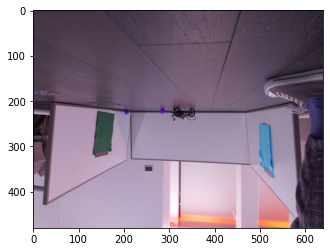

In [82]:
# After finding HSV ranges of ball colors (use some range detector tool),
# and set a video stream pointer
# Cyan:
#hsv_lower = (95, 80, 115)
#hsv_upper = (255, 255, 255)
#vs = cv2.VideoCapture('/home/pi/swc_bootcamp_2021/media/blue_ball_move.mp4')
#img = cv2.imread('/home/pi/swc_bootcamp_2021/media/blue_ball.jpg')
# Pink:
hsv_lower = (160, 160, 140)
hsv_upper = (255, 255, 255)
vs = cv2.VideoCapture('/home/pi/swc_bootcamp_2021/media/ben_pink_ball_move.h264')
img = cv2.imread('/home/pi/swc_bootcamp_2021/footballbots/goalimages/red3.jpg')
frame = img
frame = imutils.resize(frame, width=640, height=480)
#frame = imutils.resize(frame, width=480)
plt.imshow(frame)

In [83]:
col_ranges = {
        'lower_hsv_ball': (160, 160, 140),
        'upper_hsv_ball': (255, 255, 255),
        'lower_rgb_ball': (100, 0, 50),
        'upper_rgb_ball': (255, 70, 200),
        'lower_rgb_yellow': (180, 120, 50),
        'upper_rgb_yellow': (220, 160, 80),
        'lower_rgb_green': (50, 50, 50),
        'upper_rgb_green': (110, 120, 60),
    }
lower = col_ranges['lower_rgb_green']
upper = col_ranges['upper_rgb_green']

In [84]:
# (works well for ball)
# Tracking on single image: 
# Steps: 0) resize; 1) blur; 2) convert to HSV-space; 3) mask based on
# upper and lower hsv bounds; 4) dilate; 5) erode; 6) find contours;
# 7) find largest contour; 8) compute min enclosing circle and its
# center
t = time.time()
# gauss_blurred_frame = cv2.GaussianBlur(frame, GAUSS_FILT_PX_SZ, GAUSS_FILT_SIGMA)
#col_space_frame = cv2.cvtColor(gauss_blurred_frame, cv2.COLOR_BGR2RGB)
col_space_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
masked_frame = cv2.inRange(col_space_frame, lower, upper)
#dilated_frame = cv2.dilate(masked_frame, None, iterations=D_E_IT)
#dilated_frame = cv2.dilate(masked_frame, None, iterations=1)
#eroded_frame = cv2.erode(dilated_frame, None, iterations=D_E_IT)
#eroded_frame = cv2.erode(dilated_frame, None, iterations=1)
contours = cv2.findContours(eroded_frame.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
center = None
c = max(contours, key=cv2.contourArea)
((x, y), radius) = cv2.minEnclosingCircle(c)
center = np.round((x,y)).astype(int)
print(center)
print(time.time() - t)

#M = cv2.moments(c)
#center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

[156 274]
0.034416913986206055


In [77]:
#col_space_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
rgb_img = frame
rgb_img = (rgb_img[:, :, 0] > 150) * (rgb_img[:, :, 1] < 70)
#rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
masked = rgb_img.astype(np.uint8)
best_loc = None
if np.any(masked):
    contours,hierarchy = cv2.findContours(masked, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    biggest_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(biggest_contour)
    print(M)

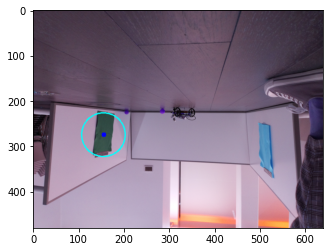

In [85]:
# Draw bounding circle
#if radius > MIN_PX_BALL_RAD:
    # draw the circle and centroid on the frame,
    # then update the list of tracked points
cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
cv2.circle(frame, center, 5, (0, 0, 255), -1)
    #cv2.imshow("Frame", frame)
plt.imshow(frame)

In [ ]:
# Get video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter('/home/pi/swc_bootcamp_2021/media/ben_pink_ball_tracked.mp4', fourcc, fps=20.0, frameSize=(640,  480), isColor=True)

In [ ]:
# Tracking via video:

# Get video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter('/home/pi/swc_bootcamp_2021/media/ben_pink_ball_tracked.mp4', fourcc, fps=20.0, frameSize=(640,  480), isColor=True)

while True:
    frame = vs.read()
    if not frame[0]:  # end of video
        break
    frame = frame[1]
    gauss_blurred_frame = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv_frame = cv2.cvtColor(gauss_blurred_frame, cv2.COLOR_BGR2HSV)
    masked_frame = cv2.inRange(hsv_frame, hsv_lower, hsv_upper)
    dilated_frame = cv2.dilate(masked_frame, None, iterations=2)
    eroded_frame = cv2.erode(dilated_frame, None, iterations=2)
    contours = cv2.findContours(eroded_frame.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    center = None
    radius = 0
    # Only proceed with tracking if contours found in this frame
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        center = np.round((x,y)).astype(int)
    # Draw bounding circle and contrails
    if radius > MIN_PX_BALL_RAD:
        cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
        cv2.circle(frame, center, 5, (0, 0, 255), -1)
    deque_buffer.appendleft(center)
    for i in range(1, len(deque_buffer)):
        if deque_buffer[i - 1] is None or deque_buffer[i] is None:
            continue
        else:
            thickness = int(np.sqrt(DEQUE_BUFF_LEN / float(i + 1)) * 2.5)
            cv2.line(frame, deque_buffer[i - 1], deque_buffer[i], (0, 0, 255), thickness)
    # Write out frame
    #cv2.imshow("Frame", frame)
    #plt.imshow(frame)
    writer.write(frame)

# At end of video, close video files, clean up..
vs.release()
writer.release()
cv2.destroyAllWindows()

In [ ]:
ap = argparse.ArgumentParser()
ap.add_argument("--video", default=None, help="path to the (optional) video file")
ap.add_argument("--frame-size", default=[640, 480], help="frame size of frames in video")
ap.add_argument("--ball-color", default='pink', help="ball color ('pink' or 'cyan')")
ap.add_argument("--write-file", default=None, help="path to name of video file to write to")
ap.add_argument("--write-stream", default=False, help="writes to web server stream if True")
ap.add_argument("--deque-buffer-size", type=int, default=16, help="max buffer size")
ap.add_argument("--gaussian-filter-params", default=[5, 5, 1], help="3 numbers: filter kernel width, height, and sigma (default: [5, 5, 1])")
ap.add_argument("--min-ball-radius", default=10, help="pixels for ball radius for visualization of tracking")
ap.add_argument("--send-serial", default=False, help="send position of ball relative to center to serial")
ap.add_argument("--move-thresh", default=30, help="pixels threshold for determining movement")

args = vars(ap.parse_known_args()[0])
args

In [ ]:
# Set vals from input args
FRAME_CENTER = (args['frame_size'][0] / 2, args['frame_size'][1] / 2)
MOVE_THRESH = args['move_thresh']
GAUSS_FILT_PARAMS = args['gaussian_filter_params']
MIN_PX_BALL_RAD = args['min_ball_radius']
D_E_IT = 2;  # dilation/erosion iterations
GAUSS_FILT_PARAMS = args['gaussian_filter_params']
MIN_PX_BALL_RAD = args['min_ball_radius']
D_E_IT = 2;  # dilation/erosion iterations
deque_buffer = deque(maxlen=args['deque_buffer_size'])
FRAME_CENTER
args['ball_color'] is 'pink'

In [ ]:
ord('q')

In [ ]:
if (cv2.pollKey() == 10):
    print('hi')